In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgbm
import os
import csv
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
%matplotlib inline

### Read input dataset as dataframe

In [130]:
input_path = r'C:\Users\baharudin.ahmad\Documents\analytics\supervised_machine_learning\lightgbm\input'
output_path = r'C:\Users\baharudin.ahmad\Documents\analytics\supervised_machine_learning\lightgbm\output'

train_file_name = 'train.csv'
test_file_name = 'test.csv'
submission_file_name = 'gender_submission.csv'

train_df = pd.read_csv(os.path.join(input_path, train_file_name), encoding='utf-8')
test_df = pd.read_csv(os.path.join(input_path, test_file_name), encoding='utf-8')
sample_submission = pd.read_csv(os.path.join(input_path, submission_file_name), encoding='utf-8')

In [131]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [132]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [133]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### Prepare training dataset

In [134]:
# SexとEmbarkedのOne-Hotエンコーディング
train = pd.get_dummies(train_df, columns=['Sex', 'Embarked'])
test = pd.get_dummies(test_df, columns=['Sex', 'Embarked'])
 # 補足 : Sexは2値なので、One-Hotエンコーディングは不要(してもいいが普通はしない)ですが、今回は行なっています

# 不要な列の削除
train.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

# trainの表示
display(train.head())

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [135]:
X_train = train.drop(['Survived'], axis=1)  # X_trainはtrainのSurvived列以外
Y_train = train['Survived']  # Y_trainはtrainのSurvived列


# X_trainとY_trainをtrainとvalidに分割
train_x, valid_x, train_y, valid_y = train_test_split(X_train, Y_train, test_size=0.33, random_state=0)

### Define hyperparameters for LGBM

In [136]:
# LightGBMの分類器をインスタンス化
gbm = lgb.LGBMClassifier(
                objective = 'binary',
                #metric = "binary_logloss",
                #boosting_type = 'dart', 'gbdt'
                num_leaves = 10,
                learning_rate = 0.05,
                        )

### Train the model

In [137]:
# trainとvalidを指定し学習
gbm.fit(train_x, train_y, eval_set = [(valid_x, valid_y)],
                 early_stopping_rounds = 20,
                 verbose = 10,
                eval_metric = ['auc', 'binary_logloss']
       );

Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.848144	valid_0's binary_logloss: 0.521929
[20]	valid_0's auc: 0.86604	valid_0's binary_logloss: 0.460433
[30]	valid_0's auc: 0.865795	valid_0's binary_logloss: 0.431153
[40]	valid_0's auc: 0.870667	valid_0's binary_logloss: 0.415007
[50]	valid_0's auc: 0.871891	valid_0's binary_logloss: 0.407916
[60]	valid_0's auc: 0.868708	valid_0's binary_logloss: 0.405338
Early stopping, best iteration is:
[49]	valid_0's auc: 0.874217	valid_0's binary_logloss: 0.407938


### Plot SHAP

In [138]:
import shap

explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [139]:
# Visualize a single prediction
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_train.iloc[0,:])

In [140]:
# Visualize many predictions
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_train.iloc[:1000,:])

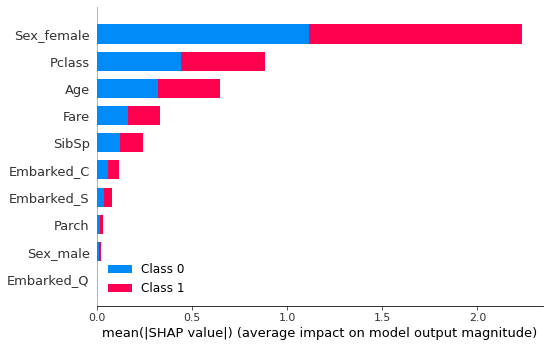

In [141]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


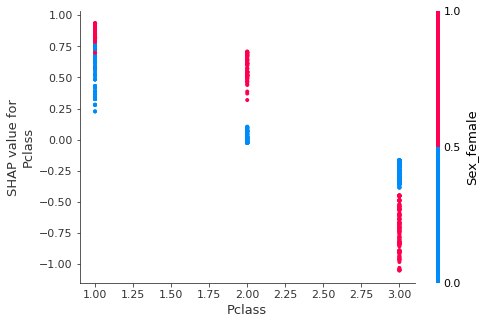

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


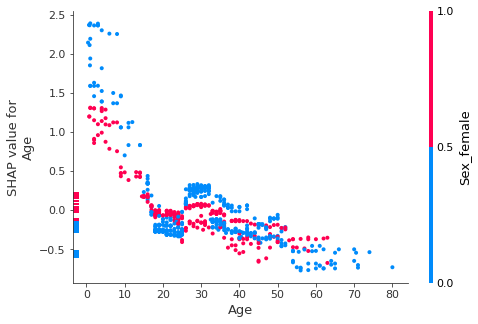

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


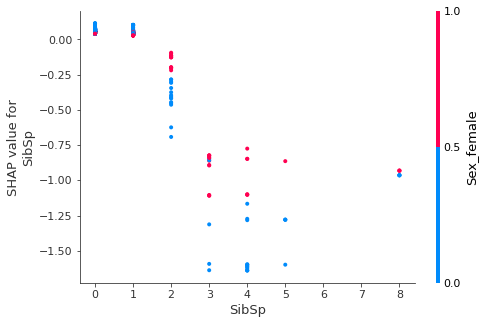

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


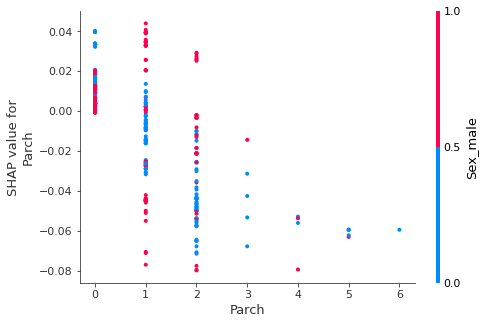

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


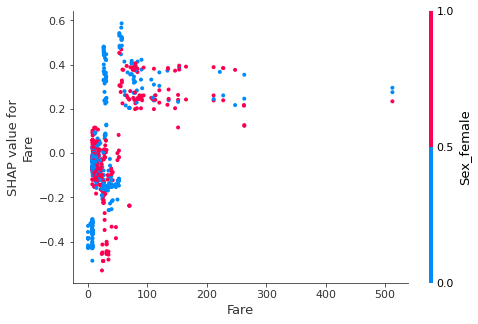

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


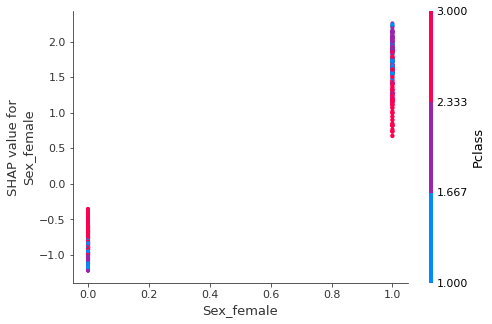

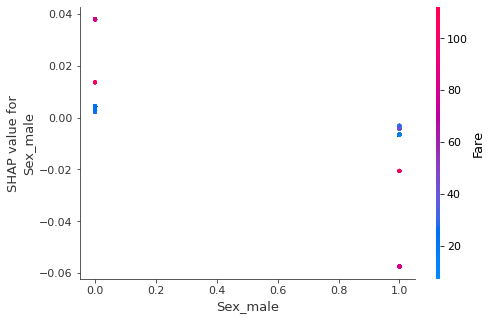

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


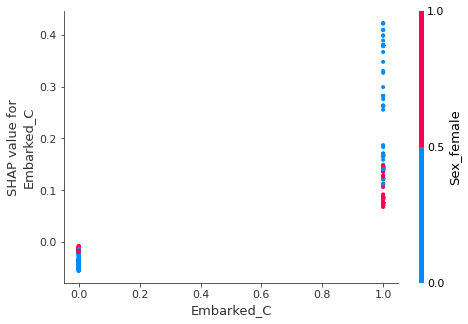

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


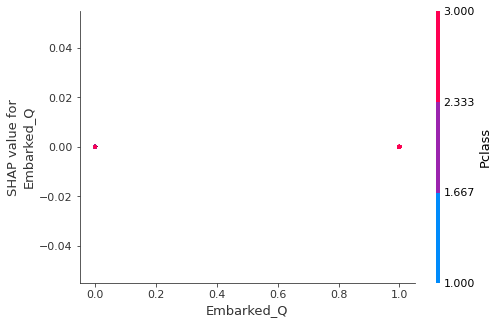

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


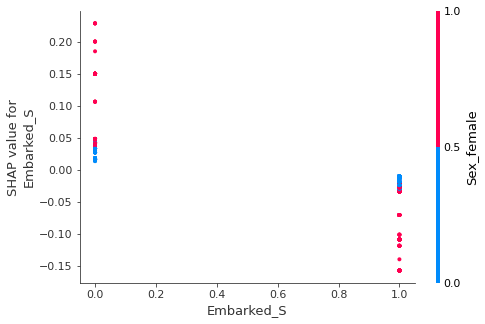

In [142]:
# SHAP Dependence Plots
for name in train_x.columns:
    shap.dependence_plot(name, shap_values[1], X_train, display_features=X_train)

### Examine model performance

In [143]:
# oof = Out of Fold
# out of foldは学習に使っているデータ以外の予測
oof = gbm.predict(valid_x, num_iteration=gbm.best_iteration_)  # oofはout of fold
print('score', round(accuracy_score(valid_y, oof)*100,2), '%')  # 正解率の表示

score 81.69 %


### Make predictions on the test set

In [144]:
# testの予測
test_pred = gbm.predict(test, num_iteration=gbm.best_iteration_)  # testの予測
sample_submission['Survived'] = test_pred  # sample_submissionのSurvived列をtest_predに置き換え

### Save test prediction results as csv

In [145]:
sample_submission.to_csv(os.path.join(output_path,'train_test_split.csv'), header=True, index=False, mode='w', encoding='utf-8') # csvファイルの書き出し